In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance
import math

# Konfiguracja wyświetlania
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

**Zadanie 1**

In [2]:
# 1. Odtworzenie danych
data = {
    'Wzrost (cm)': [190, 172],
    'Waga (kg)': [88, 70],
    'Staz (lata)': [3, 12],
    'Zarobki (tys.)': [3.5, 4.3],
    'Ocena (pkt.)': [7, 5],
    'Piętro': [6, 1],
    'Dzieci': [1, 4],
    'Odleglosc (km)': [25, 12]
    # Pomijam kolumnę kategoryczną 'Ubezp.' do obliczeń numerycznych
}
df = pd.DataFrame(data, index=['A', 'B'])
print("Dane oryginalne:\n", df)

# Funkcja pomocnicza do obliczania Euklidesa
def calc_euclidean(row1, row2):
    return np.sqrt(np.sum((row1 - row2)**2))

# 2. Odległość Euklidesowa dla danych oryginalnych
dist_orig = calc_euclidean(df.loc['A'], df.loc['B'])
print(f"\nOdległość Euklidesowa (oryginał): {dist_orig:.4f}")

# 3. Zmiana skali zarobków (tys -> PLN)
df_scaled_salary = df.copy()
df_scaled_salary['Zarobki (tys.)'] = df_scaled_salary['Zarobki (tys.)'] * 1000
dist_salary = calc_euclidean(df_scaled_salary.loc['A'], df_scaled_salary.loc['B'])
print(f"Odległość po zmianie skali zarobków (x1000): {dist_salary:.4f}")
print("Wniosek: Atrybut o dużej skali (zarobki w PLN) całkowicie zdominował odległość.")

# 4. Standaryzacja (dzielenie przez odchylenie standardowe)
#  ddof=0 dla populacji, ddof=1 dla próby. Tutaj użyjemy ddof=1 (standard pandas)
std_devs = df.std()
df_normalized = df / std_devs
dist_norm = calc_euclidean(df_normalized.loc['A'], df_normalized.loc['B'])
print(f"Odległość po normalizacji (dzielenie przez STD): {dist_norm:.4f}")

# 5. Odległość Minkowskiego i Manhattan (City Block) dla danych znormalizowanych
# Manhattan (p=1), Euklides (p=2), Minkowski (ogólna)
vec_a = df_normalized.loc['A']
vec_b = df_normalized.loc['B']

dist_manhattan = distance.cityblock(vec_a, vec_b)
dist_minkowski_3 = distance.minkowski(vec_a, vec_b, p=3) # Przykładowe p=3

print(f"Odległość Manhattan (A, B): {dist_manhattan:.4f}")
print(f"Odległość Minkowskiego (p=3) (A, B): {dist_minkowski_3:.4f}")

Dane oryginalne:
    Wzrost (cm)  Waga (kg)  Staz (lata)  Zarobki (tys.)  Ocena (pkt.)  Piętro  \
A          190         88            3             3.5             7       6   
B          172         70           12             4.3             5       1   

   Dzieci  Odleglosc (km)  
A       1              25  
B       4              12  

Odległość Euklidesowa (oryginał): 30.6046
Odległość po zmianie skali zarobków (x1000): 800.5848
Wniosek: Atrybut o dużej skali (zarobki w PLN) całkowicie zdominował odległość.
Odległość po normalizacji (dzielenie przez STD): 4.0000
Odległość Manhattan (A, B): 11.3137
Odległość Minkowskiego (p=3) (A, B): 2.8284


**Zadanie 2**

In [3]:
def lcs_length(X, Y):
    m = len(X)
    n = len(Y)
    # Tworzenie macierzy DP
    L = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0:
                L[i][j] = 0
            elif X[i-1] == Y[j-1]:
                L[i][j] = L[i-1][j-1] + 1
            else:
                L[i][j] = max(L[i-1][j], L[i][j-1])
    return L[m][n]

def get_D_x_y(x, y):
    lcs = lcs_length(x, y)
    # Wzór: D(x, y) = |x| + |y| - 2|LCS(x,y)|
    return len(x) + len(y) - 2 * lcs

# Testy z zadania
x1 = "abcde"
y1 = "bcdxye"
print(f"D('{x1}', '{y1}') = {get_D_x_y(x1, y1)} (Oczekiwano: 3)")

X2 = "AGGTAB"
Y2 = "GXTXAYB"
print(f"D('{X2}', '{Y2}') = {get_D_x_y(X2, Y2)} (Oczekiwano: 5)")

D('abcde', 'bcdxye') = 3 (Oczekiwano: 3)
D('AGGTAB', 'GXTXAYB') = 5 (Oczekiwano: 5)


**Zadanie 3**

In [4]:
filmy = [
    "kosmiczna stacja astronauta planeta obca",
    "astronauta rakieta księżyc misja kosmiczna",
    "wampir zamek noc krew mroczny"
]

# a. Reprezentacja wektorowa
vectorizer = CountVectorizer()
X_matrix = vectorizer.fit_transform(filmy)
feature_names = vectorizer.get_feature_names_out()

print("Macierz częstości:\n", X_matrix.toarray())
print("Słowa:", feature_names)

# b. Podobieństwo cosinusowe
cos_sim = cosine_similarity(X_matrix)
print("\nMacierz podobieństwa cosinusowego:\n", cos_sim)

# c. Analiza (indeksy: 0=film1, 1=film2, 2=film3)
print(f"Podobieństwo Film1 vs Film2: {cos_sim[0][1]:.4f}")
print(f"Podobieństwo Film1 vs Film3: {cos_sim[0][2]:.4f}")
print("Najbardziej podobne: Film 1 i Film 2 (tematyka kosmiczna).")
print("Najmniej podobne: Film 1/2 z Filmem 3 (kosmos vs horror).")

# d. Dodanie czwartego filmu
film4 = "rakieta mars astronauta czerwona planeta"
filmy_all = filmy + [film4]

X_matrix_new = vectorizer.fit_transform(filmy_all)
cos_sim_new = cosine_similarity(X_matrix_new)

# Sprawdzenie podobieństwa filmu 4 (indeks 3) do pozostałych (indeksy 0, 1, 2)
similarities_f4 = cos_sim_new[3][:-1] # Ostatni wiersz, bez samego siebie
most_similar_idx = np.argmax(similarities_f4)

print(f"\nFilm 4: '{film4}'")
print(f"Podobieństwa do filmów 1-3: {similarities_f4}")
print(f"Najbardziej podobny do filmu nr: {most_similar_idx + 1}")

Macierz częstości:
 [[1 1 0 0 0 0 0 1 1 0 1 0 0]
 [1 1 0 1 1 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 1 1 0 0 0 0 1 1]]
Słowa: ['astronauta' 'kosmiczna' 'krew' 'księżyc' 'misja' 'mroczny' 'noc' 'obca'
 'planeta' 'rakieta' 'stacja' 'wampir' 'zamek']

Macierz podobieństwa cosinusowego:
 [[1.  0.4 0. ]
 [0.4 1.  0. ]
 [0.  0.  1. ]]
Podobieństwo Film1 vs Film2: 0.4000
Podobieństwo Film1 vs Film3: 0.0000
Najbardziej podobne: Film 1 i Film 2 (tematyka kosmiczna).
Najmniej podobne: Film 1/2 z Filmem 3 (kosmos vs horror).

Film 4: 'rakieta mars astronauta czerwona planeta'
Podobieństwa do filmów 1-3: [0.4 0.4 0. ]
Najbardziej podobny do filmu nr: 1


**Zadanie 4**

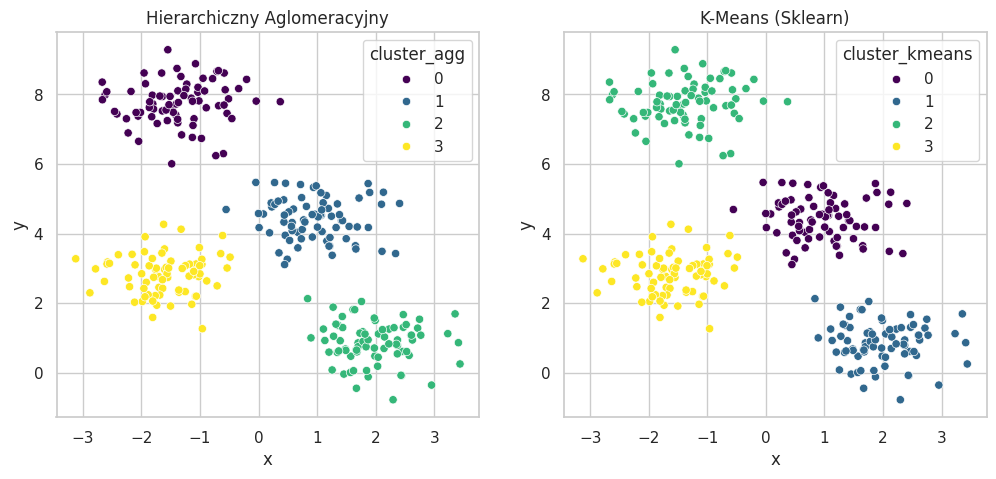

In [5]:
# A. Generowanie danych (zastępuje wczytanie k_means_data.csv)
X_kmeans, _ = datasets.make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
df_kmeans = pd.DataFrame(X_kmeans, columns=['x', 'y'])

# B. Algorytm hierarchiczny aglomeracyjny
agg_clustering = AgglomerativeClustering(n_clusters=4)
df_kmeans['cluster_agg'] = agg_clustering.fit_predict(X_kmeans)

# C. Algorytm k-średnich (Sklearn)
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
df_kmeans['cluster_kmeans'] = kmeans.fit_predict(X_kmeans)

# Wizualizacja porównawcza
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=df_kmeans, x='x', y='y', hue='cluster_agg', palette='viridis', ax=axes[0])
axes[0].set_title('Hierarchiczny Aglomeracyjny')
sns.scatterplot(data=df_kmeans, x='x', y='y', hue='cluster_kmeans', palette='viridis', ax=axes[1])
axes[1].set_title('K-Means (Sklearn)')
plt.show()

**Zadanie 5**

Zbieżność osiągnięta w iteracji 3


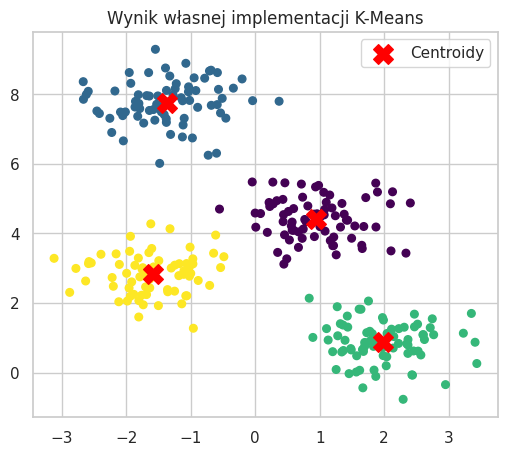

In [6]:
def simple_k_means(X, k, max_iters=100):
    # 1. Losowa inicjalizacja centroidów
    # Wybieramy k losowych punktów ze zbioru danych jako startowe centroidy
    indices = np.random.choice(len(X), k, replace=False)
    centroids = X[indices]

    for i in range(max_iters):
        # 2. Przypisanie do klastrów
        # Obliczamy odległość każdego punktu do każdego centroidu
        # cdist oblicza odległość między każdą parą z dwóch kolekcji wektorów
        distances = distance.cdist(X, centroids, 'euclidean')

        # Dla każdego punktu bierzemy indeks najbliższego centroidu
        cluster_labels = np.argmin(distances, axis=1)

        # 3. Aktualizacja centroidów
        new_centroids = []
        for j in range(k):
            # Bierzemy punkty należące do klastra j
            points_in_cluster = X[cluster_labels == j]
            if len(points_in_cluster) > 0:
                # Nowy centroid to średnia arytmetyczna punktów
                new_centroids.append(points_in_cluster.mean(axis=0))
            else:
                # Jeśli klaster pusty, zostawiamy stary (lub losujemy nowy - tu uproszczenie)
                new_centroids.append(centroids[j])

        new_centroids = np.array(new_centroids)

        # Sprawdzenie warunku stopu (czy centroidy się zmieniły?)
        if np.allclose(centroids, new_centroids):
            print(f"Zbieżność osiągnięta w iteracji {i}")
            break

        centroids = new_centroids

    return cluster_labels, centroids

# Uruchomienie własnego algorytmu
my_labels, my_centroids = simple_k_means(X_kmeans, k=4)

# Wizualizacja wyniku
plt.figure(figsize=(6, 5))
plt.scatter(X_kmeans[:, 0], X_kmeans[:, 1], c=my_labels, cmap='viridis', s=30)
plt.scatter(my_centroids[:, 0], my_centroids[:, 1], c='red', marker='X', s=200, label='Centroidy')
plt.title("Wynik własnej implementacji K-Means")
plt.legend()
plt.show()

**Zadanie 6**

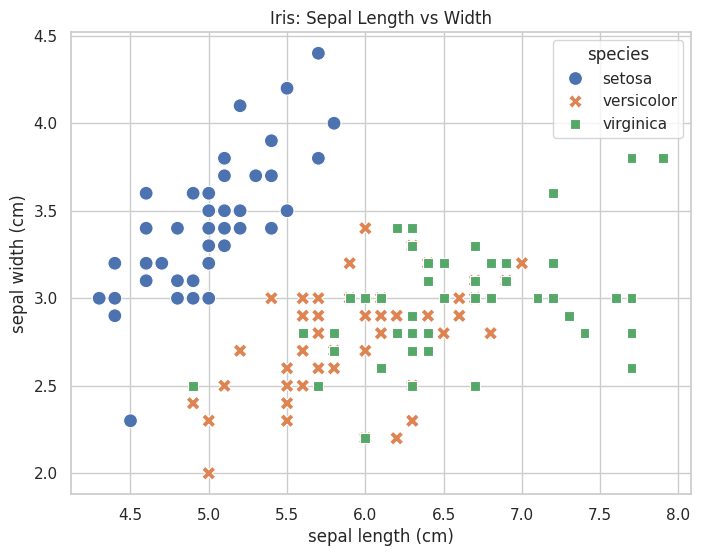


Statystyki opisowe:
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
min           4.300000          2.000000           1.000000          0.100000   
max           7.900000          4.400000           6.900000          2.500000   
std           0.828066          0.435866           1.765298          0.762238   

       target  
min  0.000000  
max  2.000000  
std  0.819232  

Wariancja (Średnie odchylenie kwadratowe):
sepal length (cm)    0.685694
sepal width (cm)     0.189979
petal length (cm)    3.116278
petal width (cm)     0.581006
dtype: float64

Macierz korelacji:
                    sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.117570           0.871754   
sepal width (cm)           -0.117570          1.000000          -0.428440   
petal length (cm)           0.871754         -0.428440           1.000000   
petal width (cm)            0.817941         -0.366126           0.962865   

    

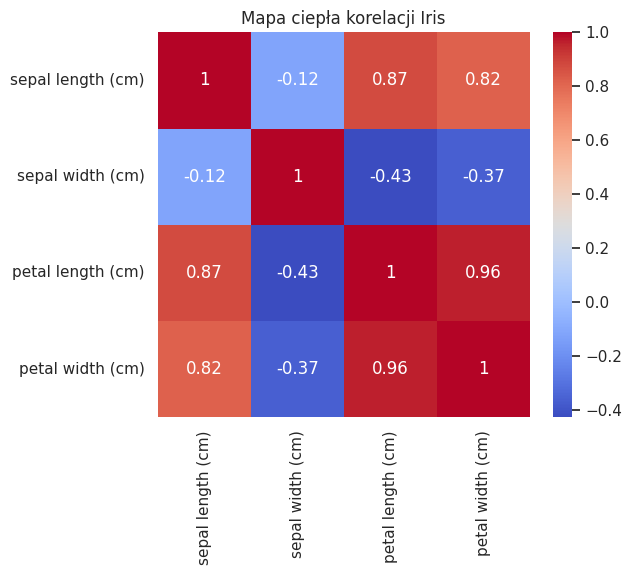

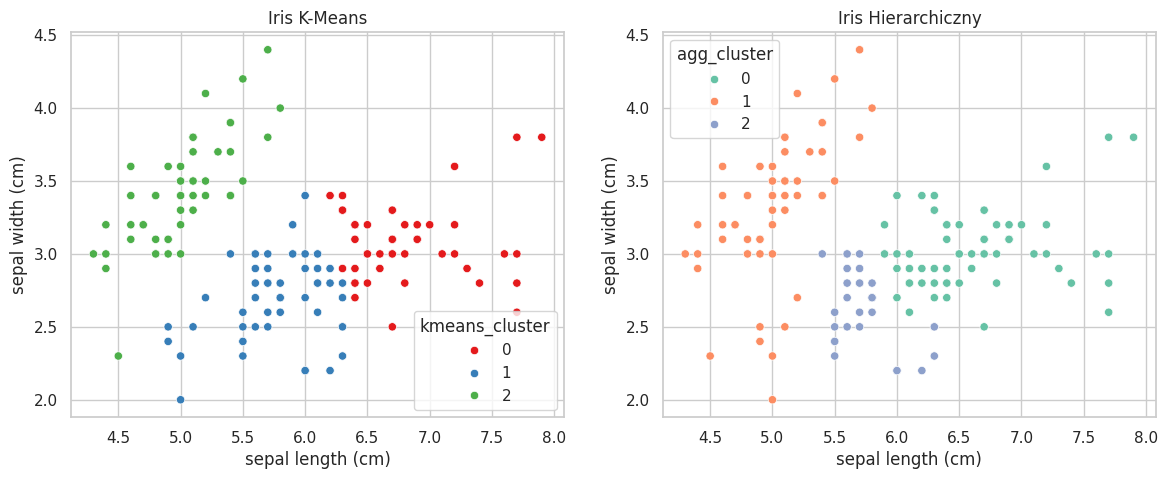

In [7]:
# 1. Załaduj zbiór danych iris
iris = datasets.load_iris()
df_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df_iris['target'] = iris.target
df_iris['species'] = df_iris['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# 2. Wykres rozrzutu sepal_length vs sepal_width
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_iris, x='sepal length (cm)', y='sepal width (cm)', hue='species', style='species', s=100)
plt.title("Iris: Sepal Length vs Width")
plt.show()

# 3. Wartości statystyczne
print("\nStatystyki opisowe:")
stats = df_iris.describe().loc[['min', 'max', 'std']]
print(stats)
# Średnie odchylenie kwadratowe to wariancja (std^2), ale zazwyczaj w analizie patrzymy na std.
print("\nWariancja (Średnie odchylenie kwadratowe):")
print(df_iris.iloc[:, :4].var())

# 4. Współczynniki korelacji
corr_matrix = df_iris.iloc[:, :4].corr()
print("\nMacierz korelacji:\n", corr_matrix)
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Mapa ciepła korelacji Iris")
plt.show()

# Wybór danych do klasteryzacji
X_iris = df_iris[['sepal length (cm)', 'sepal width (cm)']].values

# 5. Algorytm k-średnich
kmeans_iris = KMeans(n_clusters=3, random_state=42, n_init=10)
df_iris['kmeans_cluster'] = kmeans_iris.fit_predict(X_iris)

# 6. Algorytm hierarchiczny
agg_iris = AgglomerativeClustering(n_clusters=3)
df_iris['agg_cluster'] = agg_iris.fit_predict(X_iris)

# Porównanie graficzne
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(data=df_iris, x='sepal length (cm)', y='sepal width (cm)', hue='kmeans_cluster', palette='Set1', ax=ax[0])
ax[0].set_title('Iris K-Means')
sns.scatterplot(data=df_iris, x='sepal length (cm)', y='sepal width (cm)', hue='agg_cluster', palette='Set2', ax=ax[1])
ax[1].set_title('Iris Hierarchiczny')
plt.show()

**Zadanie 7**

Informacje o zbiorze:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB
None

Liczba wierszy przed usunięciem NaN: 344
Liczba wierszy po usunięciu NaN: 333


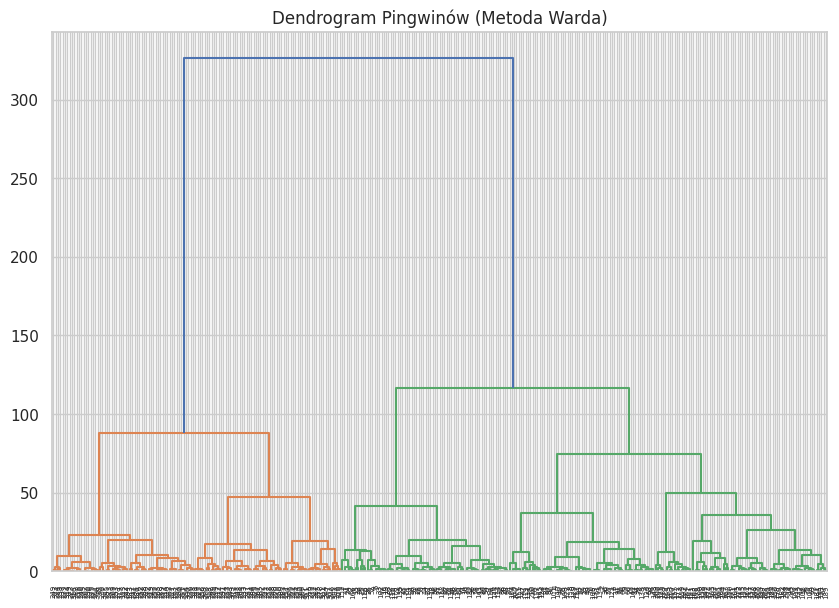

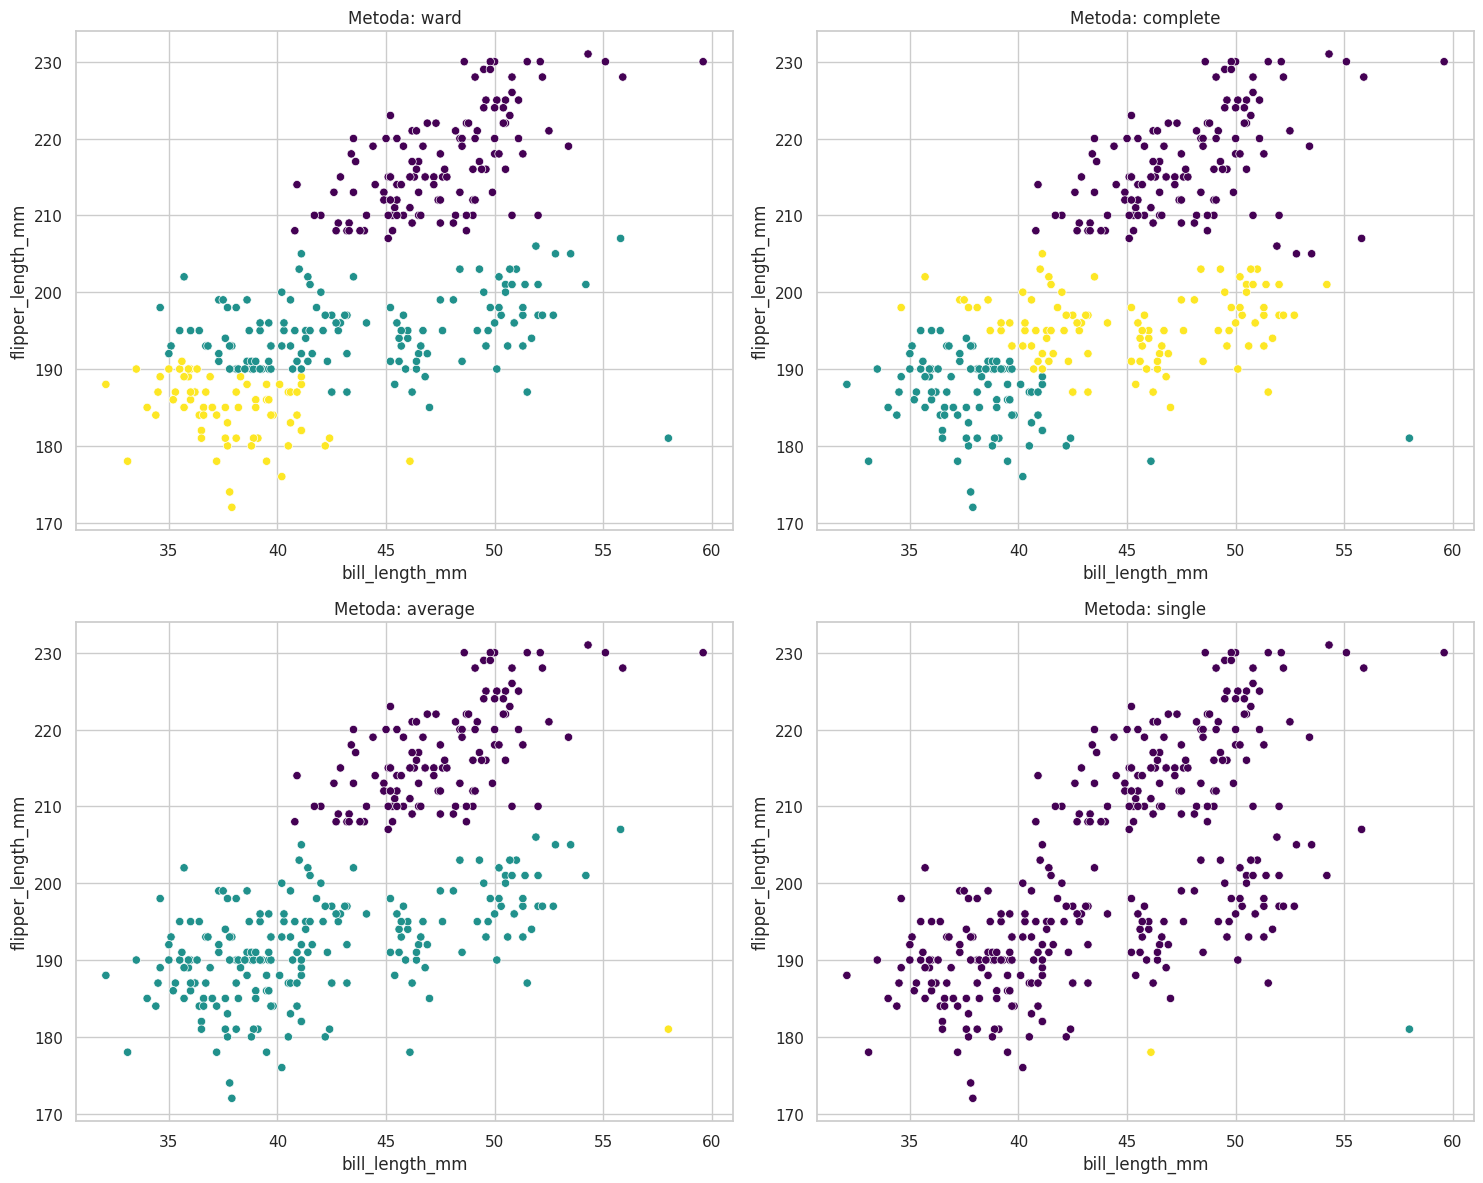

In [8]:
# Wczytanie danych z biblioteki seaborn (to samo co plik csv)
df_penguins = sns.load_dataset('penguins')

print("Informacje o zbiorze:")
print(df_penguins.info())

# 1. Usuwanie brakujących danych
print(f"\nLiczba wierszy przed usunięciem NaN: {len(df_penguins)}")
df_penguins = df_penguins.dropna()
print(f"Liczba wierszy po usunięciu NaN: {len(df_penguins)}")

# 2. Ograniczenie atrybutów
X_pen = df_penguins[['bill_length_mm', 'flipper_length_mm']]

# 3. Dendrogram (metoda Warda)
plt.figure(figsize=(10, 7))
plt.title("Dendrogram Pingwinów (Metoda Warda)")
# Zmniejszamy próbkę do rysowania dendrogramu dla czytelności, jeśli zbiór jest duży
dendro = dendrogram(linkage(X_pen, method='ward'))
plt.show()

# Interpretacja: Na dendrogramie szukamy najdłuższego pionowego odcinka,
# który nie jest przecięty przez linię poziomą. Sugeruje to optymalną liczbę klastrów.
# Dla pingwinów często naturalnym podziałem są 3 gatunki.

# 4. Klasteryzacja Hierarchiczna (dla k=3)
# Testowanie różnych metod łączenia (linkage)
methods = ['ward', 'complete', 'average', 'single']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, method in enumerate(methods):
    model = AgglomerativeClustering(n_clusters=3, linkage=method)
    labels = model.fit_predict(X_pen)

    sns.scatterplot(x=X_pen['bill_length_mm'], y=X_pen['flipper_length_mm'],
                    hue=labels, palette='viridis', ax=axes[i], legend=False)
    axes[i].set_title(f'Metoda: {method}')

plt.tight_layout()
plt.show()